In [21]:
train_size = 40000
test_size = 10000
data_dir = "set_2.1_hypershock"

In [14]:
import numpy as np

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 - 0.5
    o_y = float(y) / 2 - 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_affine_transform(theta=0, tx=0, ty=0, shear=0, zx=1, zy=1, row_axis=2, col_axis=1):
    theta = np.deg2rad(theta)
    rotation_matrix = np.array(
        [
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta), np.cos(theta), 0],
            [0, 0, 1],
        ]
    )
    transform_matrix = rotation_matrix

    shift_matrix = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])
    transform_matrix = np.dot(transform_matrix, shift_matrix)

    shear = np.deg2rad(shear)
    shear_matrix = np.array(
        [[1, -np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]]
    )
    transform_matrix = np.dot(transform_matrix, shear_matrix)

    zoom_matrix = np.array([[zx, 0, 0], [0, zy, 0], [0, 0, 1]])
    transform_matrix = np.dot(transform_matrix, zoom_matrix)

    transform_matrix = transform_matrix_offset_center(
        transform_matrix, 720, 720
    )

    if col_axis > row_axis:
        transform_matrix[:, [0, 1]] = transform_matrix[:, [1, 0]]
        transform_matrix[[0, 1]] = transform_matrix[[1, 0]]

    return transform_matrix

In [15]:
import cv2
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


# Not actually annotating the images, just displaying the bounding boxes generated from unity
def annotate(i, image, sub=None, is_json=False, preprocessed=False):
    print(is_json)
    if is_json:
        with open(f'../TrainingData/TrainingKeys/image_{i}.json', "r") as json_file:
            json_data = json.load(json_file)

        if preprocessed:
            x = int(json_data["transformedPoint"]["x"])
            y = int(json_data['transformedPoint']['y'])
            w = int(json_data["transformedPoint"]["z"])
            h = int(json_data["transformedPoint"]["w"])
        else:
            x = int(json_data["position"]["x"])
            y = int(json_data['position']['y'])
            w = int(json_data["position"]["z"])
            h = int(json_data["position"]["w"])
        print(json_data)
    else:
        with open(f'datasets/{data_dir}/train/labels/image_{i}.txt', "r") as file:
            data = file.read().split(' ')
            x = float(data[1])*720
            y = float(data[2])*720
            w = float(data[3])*720
            h = float(data[4])*720

    x1 = x + w/2
    x2 = x - w/2
    y1 = y + h/2
    y2 = y - h/2

    if sub:
        ax = sub
    else:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    ax.imshow(image)

    rect = patches.Rectangle((x2, y2), w, h, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    # rect1 = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=2, edgecolor='b', facecolor='none')
    # ax.add_patch(rect1)
    circle = patches.Circle((x, y), radius=5, color='b')
    ax.add_patch(circle)

    plt.axis('off')

    if sub:
        ax.axis('off')
    else:
        plt.axis('off')
        plt.show()

# Shows results of yolo model prediction
def predict(model, img):
    results = model(img)
    for r in results:
        im_array = r.plot()
        im = Image.fromarray(im_array[..., ::-1])
        plt.figure(figsize=(10, 10))
        plt.imshow(im)
        plt.axis('off')
        plt.show()

33
(720, 720, 3) uint8 184 0
False
28
(720, 720, 3) uint8 252 0
False
29
(720, 720, 3) uint8 254 0
False
17
(720, 720, 3) uint8 215 0
False


{'position': {'w': 84.59637451171875,
  'x': 1096.749267578125,
  'y': 506.43096923828125,
  'z': 132.3350830078125},
 'rotation': 163.29689025878906,
 'transformedPoint': {'w': 62.73388671875,
  'x': 598.39404296875,
  'y': 642.0845947265625,
  'z': 89.9605712890625}}

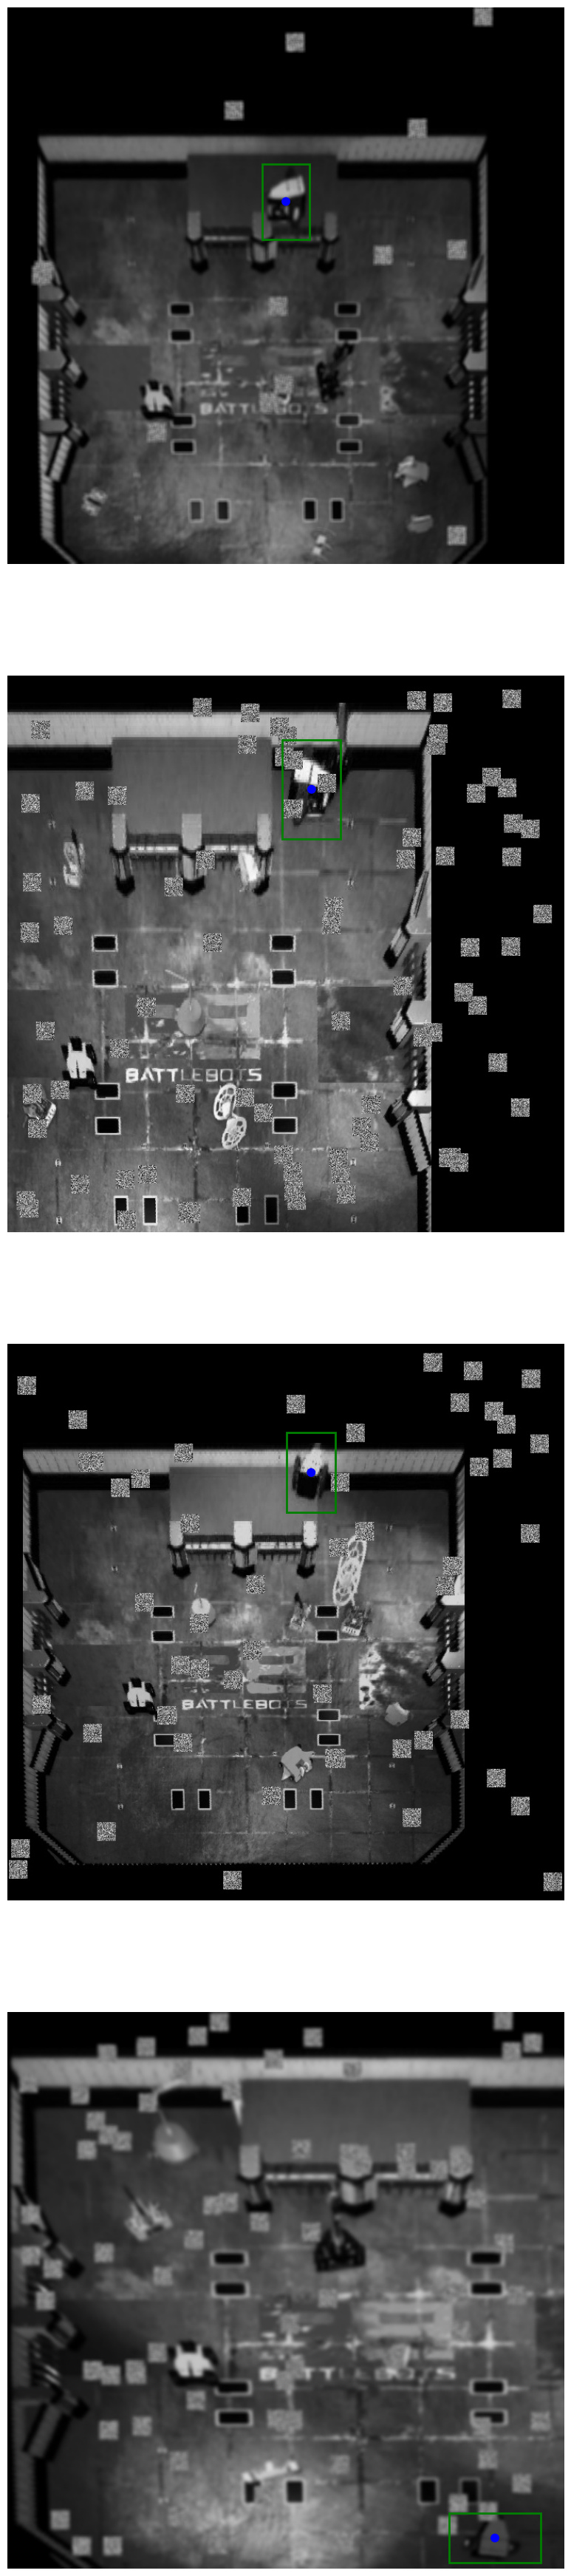

In [22]:
import numpy as np

num_img = 4
plt_size = 20

is_json = False
preprocessed = True

# Picks random images to show the boudning boxes from unity
if num_img != 1:
    fig, ax = plt.subplots(num_img, 1, figsize=(plt_size, 720/1280*num_img*plt_size))
j = 0
for i in np.random.randint(0, 40, num_img):
    print(i)
    if is_json:
        if preprocessed:
            img = cv2.imread(f'../TrainingData/TrainingInputsPosition/image_{i}.jpg', cv2.IMREAD_COLOR)
        else:
            img = cv2.imread(f'../TrainingData/TrainingInputs/image_{i}.jpg', cv2.IMREAD_COLOR)
    else:
        img = cv2.imread(f'datasets/{data_dir}/train/images/image_{i}.jpg', cv2.IMREAD_COLOR)
    print(img.shape, img.dtype, img.max(), img.min())
    if num_img == 1:
        annotate(i, img, is_json=is_json, preprocessed=preprocessed)
    else:
        annotate(i, img, ax[j], is_json=is_json, preprocessed=preprocessed)
    j += 1

{'position': {'w': 84.59637451171875, 'x': 1096.749267578125, 'y': 506.43096923828125, 'z': 132.3350830078125}, 'rotation': 163.29689025878906, 'transformedPoint': {'w': 62.73388671875, 'x': 598.39404296875, 'y': 642.0845947265625, 'z': 89.9605712890625}}


In [8]:
import cv2

def grayscale(img, show=False, save=False):
    gray_img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
        plt.show()
    if save:
        cv2.imwrite(img, gray_img)
    return gray_img


In [20]:
import json
import sys
from importlib import reload

sys.path.append('..')
import Utilities
reload(Utilities)
from Utilities import prepare_and_augment_image
sys.path.remove('..')


def get_info(i, augs):
    # img = cv2.imread(f'datasets/{data_dir}/train/images/image_{i}.jpg')
    img = cv2.imread(f"../TrainingData/TrainingInputsPosition/image_0.jpg")

    # with open(f'datasets/{data_dir}/keys/image_{i}.json', "r") as json_file:
    with open(f"../TrainingData/TrainingKeys/image_{i}.json", "r") as json_file:
        json_data = json.load(json_file)

    x = int(json_data["transformedPoint"]["x"])
    y = int(json_data['transformedPoint']['y'])
    w = int(json_data["transformedPoint"]["z"])
    h = int(json_data["transformedPoint"]["w"])

    aug_img, params = prepare_and_augment_image(img, augs)

    theta = params['theta']
    tx = params['tx']
    ty = params['ty']
    zx = params['zx']
    zy = params['zy']
    shear = params['shear']

    matrix = apply_affine_transform(theta, tx, ty, shear, zx, zy, row_axis=1, col_axis=2)
    a = matrix[0,0]
    b = matrix[0,1]
    c = matrix[0,2]
    d = matrix[1,0]
    e = matrix[1,1]
    f = matrix[1,2]

    return img,aug_img,x,y,w,h,params,tx,ty,zx,zy,theta,matrix,a,b,c,d,e,f

def draw_box(x, y, w, h, c):   
    x2 = x - w/2
    y2 = y - h/2
    rect = patches.Rectangle((x2, y2), w, h, linewidth=2, edgecolor=c, facecolor='none')
    axs[0].add_patch(rect)
    circle = patches.Circle((x, y), radius=5, color='b')
    axs[0].add_patch(circle)


406.8580765449694 657.8516623299807 93.14767793691507 102.73740491816609
283 651
[[  0.7494836    0.         157.95096844]
 [  0.           0.73002357 -14.01598384]
 [  0.           0.           1.        ]]
{'theta': 0, 'tx': -111.07251191209427, 'ty': 67.89032232021655, 'shear': 0, 'zx': 0.7300235658698168, 'zy': 0.749483599097458, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': 1.1703324427522028}


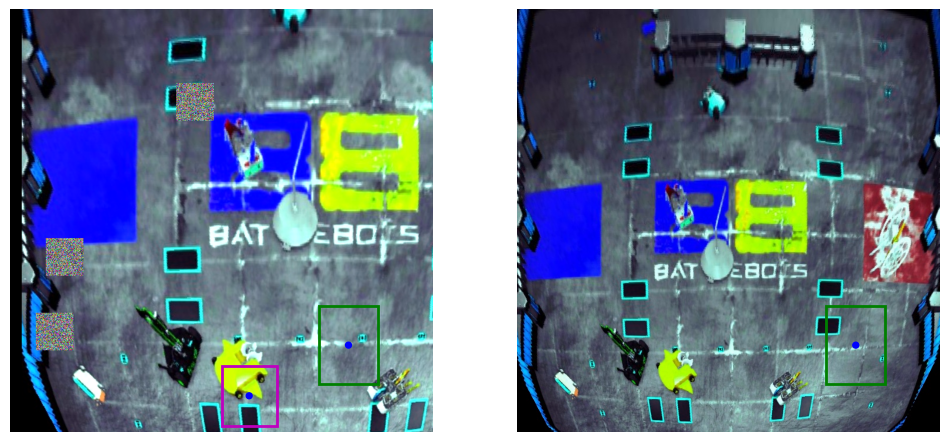

507.2559497264134 251.06433365962943 46.36236226740001 67.85478648904676
369 286
[[   1.07582683    0.           15.89825323]
 [   0.            0.99218413 -134.29130239]
 [   0.            0.            1.        ]]
{'theta': 0, 'tx': -137.10110820526958, 'ty': 43.15799941946374, 'shear': 0, 'zx': 0.9921841284680438, 'zy': 1.0758268322277278, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': 0.8991567149733013}


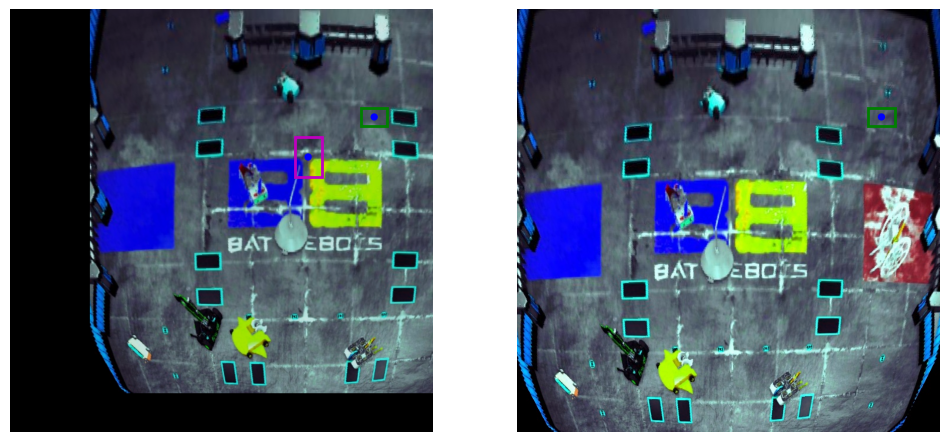

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/test_set/train/labels/image_12.txt'

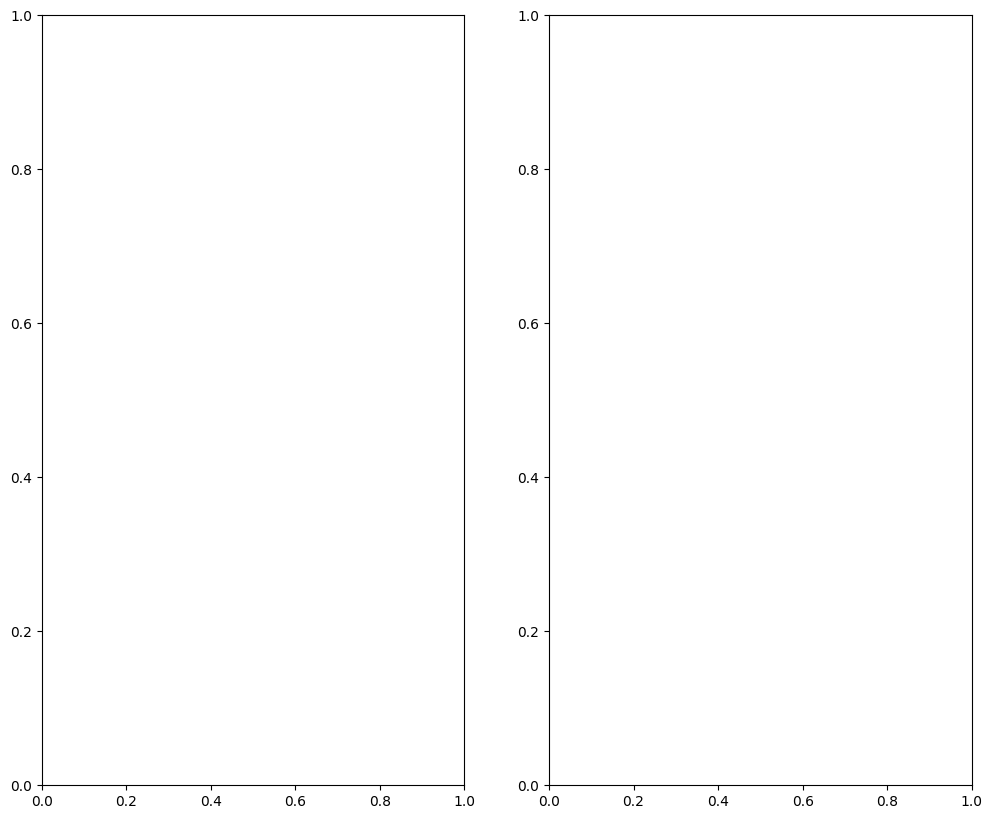

In [21]:
import cv2
import sys
import matplotlib.pyplot as plt
from importlib import reload

sys.path.append('..')
import Utilities
reload(Utilities)
from Utilities import Augmentations
sys.path.remove('..')

import cv2
import numpy as np

augs = Augmentations(
    zoom_range = 0.3, #0.3
    width_shift_range = 0.2, #0.2
    height_shift_range = 0.2, #0.2
    shear_range = 0,
    rotation_range = 0, #20
    brightness_range = [0.7, 1.3],
    max_overlay_objects = 3,
    object_size = [64, 64],
    blur_probability = 0.2,
)

for i in np.random.randint(0, 40, 5):
    img,aug_img,x,y,w,h,params,tx,ty,zx,zy,theta,matrix,a,b,c,d,e,f = get_info(i, augs)

    fig, axs = plt.subplots(1, 2, figsize=(12, 10))
    annotate(i, aug_img, sub=axs[0])
    annotate(i, img,sub=axs[1])

    w /= zx
    h /= zy
    
    # x1 = (x-tx-720/2*(1-zx))/zx
    # y1 = (y-ty-720/2*(1-zy))/zy
    # draw_box(x1, y1, w, h, 'r')


    x2 = (x-f-d*y)/e
    y2 = (y-c-b*x)/a
    if x2 - w/2 < 0:
        if x2 + w/2 > 0:
            x2 = 0 + (x2 + w/2 - 0) / 2
            w = x2 + w/2 - 0
        else:
            continue
    if x2 + w/2 > 720:
        if x2 - w/2 < 720:
            x2 = 720 - (720 - x2 + w/2) / 2
            w = 720 - x2 + w/2
        else:
            continue
    if y2 - h/2 < 0:
        if y2 + h/2 > 0:
            y2 = (y2 + h/2) / 2
            h = y2 + h/2
        else:
            continue
    if y2 + h/2 > 720:
        if y2 - h/2 < 720:
            y2 = 720 - (720 - y2 + h/2) / 2
            h = 720 - y2 + h/2
        else:
            continue

    draw_box(x2, y2, w, h, 'm')

    print(x2, y2, w, h)

    print(x,y)
    print(matrix)
    print(params)
    plt.show()


In [45]:
from ultralytics import YOLO
import numpy as np

model1 = YOLO('model5_disarray_unpreprocessed.pt')

for i in np.random.randint(20000, 25000, 3):
    predict(model1, f'datasets/set5_disarray_unpreprocessed/val/images/image_{i}.jpg')


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\tongg\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


: 

In [ ]:
# importing the module 
import cv2 
import numpy as np
from tqdm import tqdm

# reading the video
source = cv2.VideoCapture('terribleFight.avi') 

# Get total frames
total_frames = int(source.get(cv2.CAP_PROP_FRAME_COUNT))

# Create a progress bar
progress_bar = tqdm(total=total_frames, desc="Processing frames", ncols=100)

# We need to set resolutions. 
# so, convert them from float to integer. 
frame_width = int(source.get(3)) 
frame_height = int(source.get(4)) 
   
size = (frame_width, frame_height) 

result = cv2.VideoWriter('gray1.avi',  
            cv2.VideoWriter_fourcc(*'MJPG'), 
            10, size, 0) 
  
# running the loop 
while True: 
    # extracting the frames 
    ret, img = source.read() 

    # If frame read successfully
    if ret:
        # converting to gray-scale 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

        # write to gray-scale 
        result.write(gray)

        # displaying the video 
        cv2.imshow("Live", gray) 

        # Update the progress bar
        progress_bar.update(1)
    else:
        break

    # exiting the loop 
    key = cv2.waitKey(1) 
    if key == ord("q"): 
        break

# Close the progress bar
progress_bar.close()

In [ ]:
from ultralytics import YOLO

model = YOLO('model7_orbitron_preprocessed_forks_dim_spinners.pt', task='predict')
results = model('DisarrayFight2Trimmed.avi', show=True, save=True, device=0)

In [ ]:
from ultralytics import YOLO
model = YOLO('model4_orbitron_preprocessed_forks.pt')
model.export(format='onnx')

In [ ]:
import onnxruntime as ort
import numpy as np
import cv2

ort_session = ort.InferenceSession('model4_orbitron_preprocessed_forks.onnx')
img = cv2.imread('datasets/set4_forks_preprocessed/val/images/image_20000.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (736, 736))
img = img.astype(np.float32)
img /= 255.0
img = img.transpose(2, 0, 1)
img = np.expand_dims(img, axis=0)
img.shape, img.dtype, img.max(), img.min()
# cv2.imshow('img', img[0].transpose(1, 2, 0))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
output = ort_session.run(None, {'images': img})  


In [ ]:
data = output[0][0].transpose(1,0)
print(output[0].shape)
max_conf = 0
max_d = None
for d in data:
    conf = d[4]
    # print(conf)
    if conf > max_conf:
        max_conf = conf
        max_d = d
print(max_d)
